In [204]:
# Using Facebook Prophet to predict power load based on weather information
# Testing with Seasonality and ChangPoint and Holidays in Turkey where dataset comes from
# http://archive.ics.uci.edu/ml/datasets/Combined+Cycle+Power+Plant
# Note: No DateTime in dataset so don't use Holidays options.

# Load libraries
import numpy as np

import pandas as pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 70)
import plotly.offline as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt

py.init_notebook_mode(connected =True)

from fbprophet import Prophet

%time df_powerplant = pd.read_csv('input/powerplant_output.csv')
#%time df_holidays_events = pd.read_csv('input/turkey_holidays_events.csv')
print('Data and libraries are loaded.')

CPU times: user 19.3 ms, sys: 2.89 ms, total: 22.2 ms
Wall time: 35.6 ms
Data and libraries are loaded.


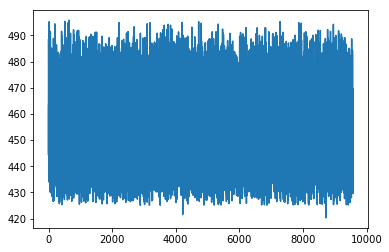

,TemperatureCelcius,ExhaustVacuumHg,AmbientPressureMillibar,RelativeHumidity,HourlyEnergyOutputMW
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90
...,...,...,...,...,...
9563,16.65,49.69,1014.01,91.00,460.03
9564,13.19,39.18,1023.67,66.78,469.62
9565,31.32,74.33,1012.92,36.48,429.57
9566,24.48,69.45,1013.86,62.39,435.74


In [22]:
# Show the current data, plotpy cannot show in github ipynb so temporaryly disable it
# py.iplot([go.Scatter(
#     x=df_powerplant.index,
#     y=df_powerplant['HourlyEnergyOutputMW']
# )])

df_powerplant['HourlyEnergyOutputMW'].plot()
plt.show()
df_powerplant

In [123]:
# Convert Scale index to DateTime Index
import datetime as dt
from datetime import timedelta

startdate =dt.datetime.strptime('09/02/1945 00:00:00','%m/%d/%Y %H:%M:%S')
for index, row in df_powerplant.iterrows():
    df_powerplant.loc[index,'ds'] = startdate+timedelta(hours=index)

df_powerplant.tail()

,TemperatureCelcius,ExhaustVacuumHg,AmbientPressureMillibar,RelativeHumidity,HourlyEnergyOutputMW,ds
9563,16.65,49.69,1014.01,91.00,460.03,1946-10-05 11:00:00
9564,13.19,39.18,1023.67,66.78,469.62,1946-10-05 12:00:00
9565,31.32,74.33,1012.92,36.48,429.57,1946-10-05 13:00:00
9566,24.48,69.45,1013.86,62.39,435.74,1946-10-05 14:00:00
9567,21.60,62.52,1017.23,67.87,453.28,1946-10-05 15:00:00


In [184]:
# Split data into four dataset to add into external regressors.
predictTime =36 #Hours

# To train with only power output
HPower=df_powerplant[['ds','HourlyEnergyOutputMW']].head(df_powerplant.shape[0]-predictTime)
HPower.columns=['ds','y']

# To train with external regressors
fulldata=df_powerplant[['ds','TemperatureCelcius','ExhaustVacuumHg','AmbientPressureMillibar','RelativeHumidity','HourlyEnergyOutputMW']]
fulldata.columns = ['ds', 'Temp','Exhaust','Pressure','Humidity','y']
train=fulldata.head(fulldata.shape[0]-predictTime)
future=fulldata[['ds', 'Temp','Exhaust','Pressure','Humidity']].tail(predictTime)

# Reset Index and remove old index column
future_y=pd.DataFrame(fulldata[['ds', 'y']].tail(predictTime)).reset_index()[['ds','y']]


In [185]:
future_y

,ds,y
0,1946-10-04 04:00:00,443.58
1,1946-10-04 05:00:00,440.97
2,1946-10-04 06:00:00,454.94
3,1946-10-04 07:00:00,440.51
4,1946-10-04 08:00:00,474.09
...,...,...
31,1946-10-05 11:00:00,460.03
32,1946-10-05 12:00:00,469.62
33,1946-10-05 13:00:00,429.57
34,1946-10-05 14:00:00,435.74


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


RMSE: 17.049298


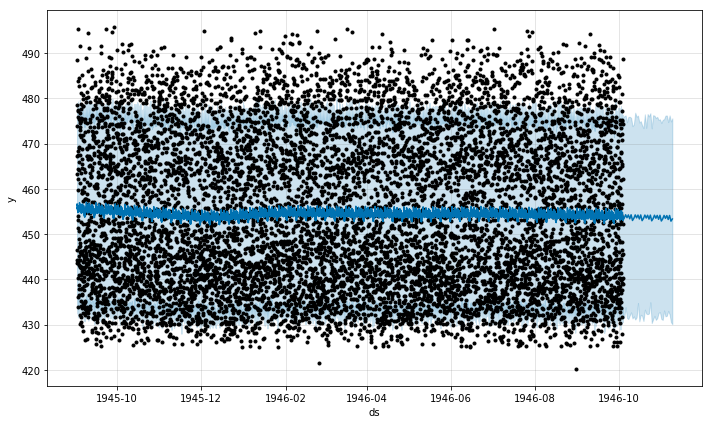

In [152]:
m = Prophet()
m.fit(HPower)
future = m.make_future_dataframe(periods=36)
forecast = m.predict(future)
print('RMSE: %f' % np.sqrt(np.mean((forecast.loc[:HPower.shape[0], 'yhat']-HPower['y'])**2))) 
m.plot(forecast)

In [157]:
train

,ds,Temp,Exhaust,Pressure,Humidity,y
0,1945-09-02 00:00:00,14.96,41.76,1024.07,73.17,463.26
1,1945-09-02 01:00:00,25.18,62.96,1020.04,59.08,444.37
2,1945-09-02 02:00:00,5.11,39.40,1012.16,92.14,488.56
3,1945-09-02 03:00:00,20.86,57.32,1010.24,76.64,446.48
4,1945-09-02 04:00:00,10.82,37.50,1009.23,96.62,473.90
...,...,...,...,...,...,...
9527,1946-10-03 23:00:00,28.96,75.23,1010.88,49.45,439.03
9528,1946-10-04 00:00:00,5.35,35.57,1027.12,80.81,488.65
9529,1946-10-04 01:00:00,20.20,64.45,1009.03,61.77,452.33
9530,1946-10-04 02:00:00,11.01,37.50,1015.08,73.36,474.36


In [193]:
# Add more external regression
me = Prophet()
me.add_regressor('Temp',prior_scale=0.5,mode='multiplicative')
me.add_regressor('Exhaust',prior_scale=0.5,mode='multiplicative')
me.add_regressor('Pressure',prior_scale=0.5,mode='multiplicative')
me.add_regressor('Humidity',prior_scale=0.5,mode='multiplicative')

me.fit(train)
forecast = me.predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


RMSE: 4.206406


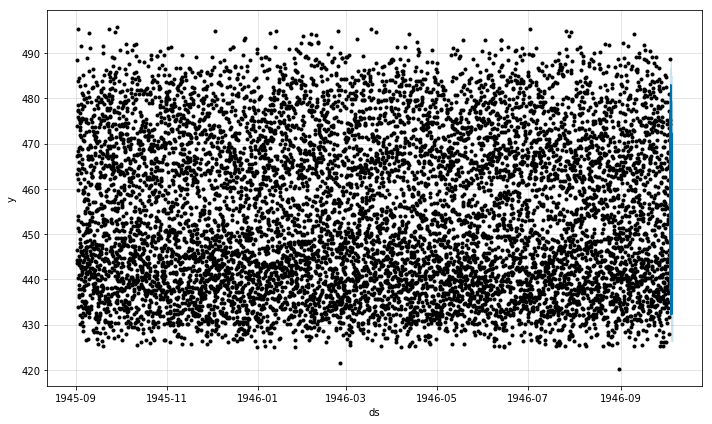

In [201]:
# Data with external regressors is competetive to H2O for all Deep learning AutoMachineLearning based on ENAS paper
# https://github.com/h2oai/h2o-tutorials/tree/master/h2o-world-2017/automl
# Prophet shows not good trend with all trained and future data

print('RMSE: %f' % np.sqrt(np.mean((forecast['yhat']-future_y['y'])**2))) 
me.plot(forecast)


In [213]:
# Plotly plots the data very clear to see, FBProphet predicts good performance
# with fast training mode and very fast for test mode.
py.iplot([
    go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='yhat'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], fill='tonexty', mode='none', name='upper'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], fill='tonexty', mode='none', name='lower'),
    go.Scatter(x=forecast['ds'], y=forecast['trend'], name='Trend'),
    go.Scatter(x=future_y['ds'], y=future_y['y'], name='y',line=dict(color=('rgb(255,0,0)'),width=3))
])